In [80]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV

In [3]:
# load data
data_train = pd.read_csv('engineered_data_train.csv')
data_test = pd.read_csv('engineered_data_test.csv')

X_train = data_train.drop('Y', axis=1)
y_train = data_train['Y']

X_test = data_test.drop('Y', axis=1)
y_test = data_test['Y']

In [4]:
from sklearn import preprocessing

def normalize(df):
    data = df.copy()
    feature_num = data.shape[1] - 1
    
    # recale features
    normalized_values = preprocessing.scale(data.iloc[:, :feature_num].values)
    for i in range(feature_num):
        data.iloc[:, i] = normalized_values[:, i]
    
    data_clean = data
    return data_clean

# scale data
X_train_scaled = normalize(X_train)
X_test_scaled = normalize(X_test)

# Logistic Regression (L2)

In [5]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', C=1e30)
lr.fit(X_train.values, y_train.values)

preds_lr = lr.predict_proba(X_test.values)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test.values, preds_lr)
auc_lr = auc(fpr_lr, tpr_lr)

accuracy_lr = accuracy_score(y_test, lr.predict(X_test))
print('Accuracy: ', accuracy_lr)

//anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy:  0.6763662171753017


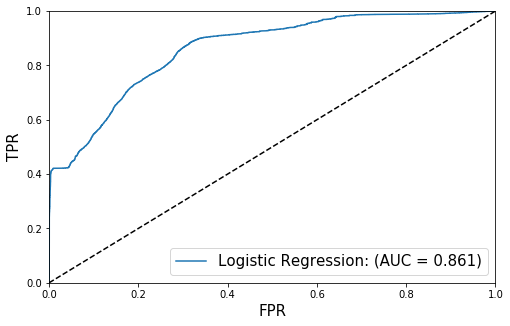

In [5]:
# plot ROC
fig = plt.figure(figsize = (8, 5))
ax = plt.subplot(111)

plt.plot(fpr_lr, tpr_lr, label='Logistic Regression: ' + '(AUC = %0.3f)'%auc_lr)
plt.plot([0,1], [0,1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR',fontsize=15)
plt.ylabel('TPR',fontsize=15)
plt.legend(fontsize=15)

# Logistic Regression (L2) with Cross Validation

In [114]:
# parameters = {'C': [10**n for n in np.arange(-8, 3, dtype=float)]}
cs = [10**n for n in np.arange(-8, 3, dtype=float)]
parameters = {'C': cs}

# scores
# def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
# def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
# def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
# def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scores = ['accuracy', 'roc_auc', 'f1', 'recall', ]

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_grid = GridSearchCV(lr, parameters, cv=5, scoring=scores, refit=False, verbose=1)
lr_grid.fit(X_train.values, y_train.values)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               0.1, 1.0, 10.0, 100.0]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['accuracy', 'roc_auc', 'f1', 'recall'], verbose=0)

In [112]:
lr_grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_test_roc_auc', 'split1_test_roc_auc', 'split2_test_roc_auc', 'split3_test_roc_auc', 'split4_test_roc_auc', 'mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'split4_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall'])

The Best c is:  3


Text(0.5, 0, 'Log10(c)')

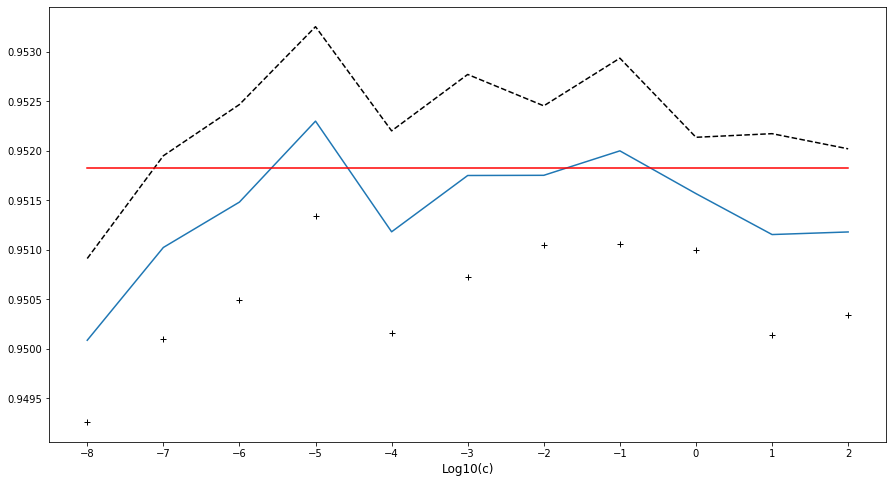

In [115]:
# plot
cs_mean = lr_grid.cv_results_['mean_test_roc_auc']
cs_std = lr_grid.cv_results_['std_test_roc_auc']
cs_ste = cs_std / np.sqrt(len(cs))
c_max_mean = np.where(cs_mean==cs_mean.max())[0][0]
print('The Best c is: ', c_max_mean)
max_1std = cs_mean[c_max_mean] - cs_ste[c_max_mean]

fig = plt.figure(figsize = (15, 8))
ax = plt.subplot(111)
plt.plot(np.log10(cs), cs_mean)
plt.plot(np.log10(cs), cs_mean-2*cs_ste, 'k+')
plt.plot(np.log10(cs), cs_mean+2*cs_ste, 'k--')
plt.plot([np.log10(cs)[0], np.log10(cs)[-1]], [max_1std, max_1std], 'r')

# plt.ylim([0.5, 0.9])
plt.xticks(np.log10(cs))
plt.xlabel('Log10(c)',fontsize=12)

In [118]:
# retrain a logistic regression with C=1e-5 with all training data
lr = LogisticRegression(penalty='l2', C=1e-5, solver='lbfgs', max_iter=1000)
lr.fit(X_train.values, y_train.values)

preds_lr = lr.predict_proba(X_test.values)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test.values, preds_lr)
auc_lr = auc(fpr_lr, tpr_lr)

accuracy_lr = accuracy_score(y_test, lr.predict(X_test))
print('Accuracy: ', accuracy_lr)

Accuracy:  0.7015170333569908


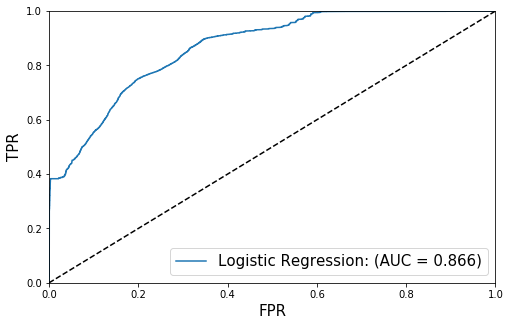

In [119]:
# plot ROC
fig = plt.figure(figsize = (8, 5))
ax = plt.subplot(111)

plt.plot(fpr_lr, tpr_lr, label='Logistic Regression: ' + '(AUC = %0.3f)'%auc_lr)
plt.plot([0,1], [0,1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR',fontsize=15)
plt.ylabel('TPR',fontsize=15)
plt.legend(fontsize=15)

# SVM (Super SLOW! Ignore for now)

In [ ]:
# from sklearn.svm import SVC

# svm = SVC(kernel="linear", probability=True, verbose=True)
# svm.fit(X_train_scaled.values, y_train.values)

# preds_svm = svm.predict_proba(X_test_scaled.values)[:, 1]

# fpr_svm, tpr_svm, _ = roc_curve(y_test.values, preds_svm)
# auc_svm = auc(fpr_svm, tpr_svm)

[LibSVM]

# Decision Tree

In [6]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train.values, y_train.values)

preds_tree = tree.predict_proba(X_test.values)[:, 1]

fpr_tree, tpr_tree, _ = roc_curve(y_test.values, preds_tree)
auc_tree = auc(fpr_tree, tpr_tree)

accuracy_tree = accuracy_score(y_test, tree.predict(X_test))
print('Accuracy: ', accuracy_tree)

Accuracy:  0.7783002129169624


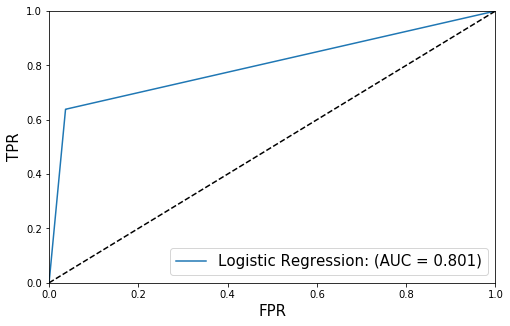

In [7]:
# plot ROC
fig = plt.figure(figsize = (8, 5))
ax = plt.subplot(111)

plt.plot(fpr_tree, tpr_tree, label='Logistic Regression: ' + '(AUC = %0.3f)'%auc_tree)
plt.plot([0,1], [0,1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR',fontsize=15)
plt.ylabel('TPR',fontsize=15)
plt.legend(fontsize=15)

# Naive Bayes

In [8]:
from sklearn.naive_bayes import BernoulliNB

nb = BernoulliNB()
nb.fit(X_train.values, y_train.values)

preds_nb = nb.predict_proba(X_test.values)[:, 1]

fpr_nb, tpr_nb, _ = roc_curve(y_test.values, preds_nb)
auc_nb = auc(fpr_nb, tpr_nb)

accuracy_nb = accuracy_score(y_test, nb.predict(X_test))
print('Accuracy: ', accuracy_nb)

Accuracy:  0.7672551454932577


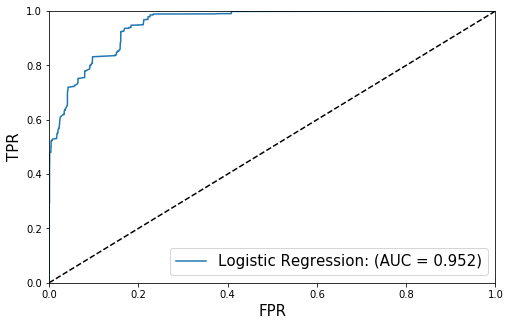

In [9]:
# plot ROC
fig = plt.figure(figsize = (8, 5))
ax = plt.subplot(111)

plt.plot(fpr_nb, tpr_nb, label='Logistic Regression: ' + '(AUC = %0.3f)'%auc_nb)
plt.plot([0,1], [0,1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR',fontsize=15)
plt.ylabel('TPR',fontsize=15)
plt.legend(fontsize=15)